In [40]:
print("Hi, I'm Shah Mohammad Rizvi! Nice to meet you.")

Hi, I'm Shah Mohammad Rizvi! Nice to meet you.


In [1]:
# Cell 1 — Mount Drive and install required packages
from google.colab import drive
drive.mount('/content/drive')

# Install additional libs (will be quiet)
!pip install -q rapidfuzz xgboost shap lime joblib
print("Installed packages: rapidfuzz, xgboost, shap, lime, joblib (if not present).")


Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 46.8 MB/s eta 0:00:00
Installed packages: rapidfuzz, xgboost, shap, lime, joblib (if not present).


In [2]:
# Cell 2 — imports & settings
import os, re, unicodedata, math, json
from pathlib import Path
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz
from tqdm.auto import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score, recall_score, classification_report, confusion_matrix, brier_score_loss, precision_recall_curve, roc_curve
from sklearn.inspection import permutation_importance
from sklearn.calibration import calibration_curve
from sklearn.utils import resample
from scipy.sparse import hstack, csr_matrix, issparse
import matplotlib.pyplot as plt
import joblib
import shap
from lime.lime_text import LimeTextExplainer

RND = 42
np.random.seed(RND)

# Small display helper
def show_df(df, n=10):
    display(df.head(n))


In [3]:
# Cell 3 — define paths & confirm files exist
base = "/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics"
p = Path(base)
processed_dir = p / "processed"
trained_dir = p / "trained_models"
lio_dir = p / "lio_results"
for d in [processed_dir, trained_dir, lio_dir]:
    d.mkdir(parents=True, exist_ok=True)

paths = {
    'main': p / "chemicals-in-cosmetics.csv",
    'prop65': p / "proposition65_clean.csv",
    'iarc': p / "List of Classifications – IARC Monographs on the Identification of Carcinogenic Hazards to Humans.csv",
    'toxcast': p / "Chemical List toxcast-2025-08-08.csv",
    'cosing': p / "coslng" / "COSING_Ingredients-Fragrance Inventory_v2.csv"
}

# confirm existence
for key, fp in paths.items():
    print(key, "->", fp, "exists?", fp.exists())
    if not fp.exists():
        raise FileNotFoundError(f"Missing {key} at {fp}")

# load (low_memory False to avoid dtypes warnings)
main_df = pd.read_csv(paths['main'], low_memory=False)
prop65_df = pd.read_csv(paths['prop65'], low_memory=False)
iarc_df = pd.read_csv(paths['iarc'], low_memory=False)
toxcast_df = pd.read_csv(paths['toxcast'], low_memory=False)
cosing_df = pd.read_csv(paths['cosing'], low_memory=False)

print("Loaded shapes:", {k: v.shape for k,v in [('main',main_df),('prop65',prop65_df),('iarc',iarc_df),('toxcast',toxcast_df),('cosing',cosing_df)]})


main -> /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/chemicals-in-cosmetics.csv exists? True
prop65 -> /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/proposition65_clean.csv exists? True
iarc -> /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/List of Classifications – IARC Monographs on the Identification of Carcinogenic Hazards to Humans.csv exists? True
toxcast -> /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/Chemical List toxcast-2025-08-08.csv exists? True
cosing -> /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/coslng/COSING_Ingredients-Fragrance Inventory_v2.csv exists? True
Loaded shapes: {'main': (112870, 22), 'prop65': (1038, 6), 'iarc': (1121, 7), 'toxcast': (4746, 14), 'cosing': (30080, 10)}


In [4]:
# Cell 4 — normalization helpers
cas_re = re.compile(r'(\d{1,7}\-\d{1,2}\-\d)')

def normalize_text(s):
    if pd.isna(s): return ""
    s = str(s).strip()
    s = unicodedata.normalize('NFKD', s)
    s = ''.join(ch for ch in s if not unicodedata.combining(ch))
    s = s.lower()
    s = re.sub(r'[^a-z0-9\-\.,\(\)\/\s]', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

def extract_cas(s):
    if pd.isna(s): return ""
    s = str(s)
    m = cas_re.search(s)
    return m.group(1) if m else ""


In [5]:
# Cell 5 — detect columns & create normalized columns
def find_col(df, candidates):
    cols = df.columns.tolist()
    for cand in candidates:
        for col in cols:
            if cand.lower() in col.lower():
                return col
    return None

chem_col = find_col(main_df, ['ChemicalName','Ingredient','Chemical Name','INCI'])
cas_col = find_col(main_df, ['CasNumber','Cas Number','CAS','CASRN'])
prod_col = find_col(main_df, ['ProductName','Product Name','Product'])
brand_col = find_col(main_df, ['BrandName','Brand','CompanyName','Company'])

print("Detected:", dict(chemical=chem_col, cas=cas_col, product=prod_col, brand=brand_col))
assert chem_col and prod_col and brand_col, "Couldn't auto-detect core columns - inspect column names."

main_df['_chem_raw'] = main_df[chem_col].astype(str)
main_df['_chem_norm'] = main_df['_chem_raw'].apply(normalize_text)
main_df['_cas_raw'] = main_df[cas_col].astype(str) if cas_col else ""
main_df['_cas'] = main_df['_cas_raw'].apply(extract_cas) if cas_col else ""
main_df['_product_name'] = main_df[prod_col].astype(str)
main_df['_brand'] = main_df[brand_col].astype(str)
main_df['_product_id'] = main_df['_brand'].str.strip() + "||" + main_df['_product_name'].str.strip()

print("Sample normalized rows:")
display(main_df[['_product_id','_chem_raw','_chem_norm','_cas']].head(8))


Detected: {'chemical': 'ChemicalName', 'cas': 'CasNumber', 'product': 'ProductName', 'brand': 'BrandName'}
Sample normalized rows:


,_product_id,_chem_raw,_chem_norm,_cas
0,AVON||ULTRA COLOR RICH EXTRA PLUMP LIPSTICK-AL...,Titanium dioxide,titanium dioxide,13463-67-7
1,Glover's||Glover's Medicated Shampoo,Distillates (coal tar),distillates (coal tar),65996-92-1
2,Glover's||Glover's Medicated Shampoo,Estragole,estragole,140-67-0
3,AVON||PRECISION GLIMMER EYE LINER-ALL SHADES �,Titanium dioxide,titanium dioxide,13463-67-7
4,AVON||AVON BRILLIANT SHINE LIP GLOSS-ALL SHADES �,Titanium dioxide,titanium dioxide,13463-67-7
5,AVON||JILLIAN DEMPSEY FOR AVON CELESTIAL EYESH...,Titanium dioxide,titanium dioxide,13463-67-7
6,OPI||ABSOLUTE Precision Color Powder System - ...,Titanium dioxide,titanium dioxide,13463-67-7
7,OPI||ABSOLUTE Precision Color Powder System - ...,Titanium dioxide,titanium dioxide,13463-67-7


In [6]:
# Cell 6 — dedupe exact duplicate rows (product x ingredient x cas)
main_df['_dedupe_key'] = main_df['_product_id'].fillna('') + "||" + main_df['_chem_norm'].fillna('') + "||" + main_df['_cas'].fillna('')
before = len(main_df)
main_dedup = main_df.drop_duplicates(subset=['_dedupe_key']).reset_index(drop=True)
after = len(main_dedup)
print(f"Rows before dedupe: {before:,} -> after: {after:,} (removed {before-after:,})")
main_dedup.to_csv(processed_dir / "main_deduped_rows.csv", index=False)
print("Saved main_deduped_rows.csv")


Rows before dedupe: 112,870 -> after: 39,405 (removed 73,465)
Saved main_deduped_rows.csv


In [7]:
# Cell 7 — normalize prop65, iarc, toxcast, cosing (auto-detect name/cas columns)
def auto_name_cas(df):
    name = find_col(df, ['Name','ChemicalName','INCI','Preferred Name','PREFERRED NAME','SUBSTANCE'])
    cas = find_col(df, ['CAS','CASRN','CAS No','CAS Number','CASNumber','RN'])
    return name, cas

p65_name, p65_cas = auto_name_cas(prop65_df)
iarc_name, iarc_cas = auto_name_cas(iarc_df)
tox_name, tox_cas = auto_name_cas(toxcast_df)
cos_name, cos_cas = auto_name_cas(cosing_df)

print("Detected mapping cols:", {'prop65':(p65_name,p65_cas),'iarc':(iarc_name,iarc_cas),'tox':(tox_name,tox_cas),'cosing':(cos_name,cos_cas)})

# add normalized columns
if p65_name: prop65_df['_name_norm'] = prop65_df[p65_name].astype(str).apply(normalize_text)
else: prop65_df['_name_norm'] = ""
prop65_df['_cas'] = prop65_df[p65_cas].astype(str).apply(extract_cas) if p65_cas else ""

if iarc_name: iarc_df['_name_norm'] = iarc_df[iarc_name].astype(str).apply(normalize_text)
else: iarc_df['_name_norm'] = ""
iarc_df['_cas'] = iarc_df[iarc_cas].astype(str).apply(extract_cas) if iarc_cas else ""

if tox_name: toxcast_df['_name_norm'] = toxcast_df[tox_name].astype(str).apply(normalize_text)
else: toxcast_df['_name_norm'] = ""
toxcast_df['_cas'] = toxcast_df[tox_cas].astype(str).apply(extract_cas) if tox_cas else ""

if cos_name: cosing_df['_name_norm'] = cosing_df[cos_name].astype(str).apply(normalize_text)
else: cosing_df['_name_norm'] = ""
cosing_df['_cas'] = cosing_df[cos_cas].astype(str).apply(extract_cas) if cos_cas else ""

print("Auth lists normalized.")


Detected mapping cols: {'prop65': (None, 'CAS No.'), 'iarc': (None, 'CAS No.'), 'tox': ('PREFERRED NAME', 'CASRN'), 'cosing': ('INCI name', 'CAS No')}
Auth lists normalized.


In [8]:
# Cell 8 — chemical-level table from deduped rows and exact match labeling
chem_unique = (main_dedup[['_chem_raw','_chem_norm','_cas']]
               .drop_duplicates()
               .rename(columns={'_chem_raw':'chemical_name_raw','_chem_norm':'chemical_name_norm','_cas':'cas'})
               .reset_index(drop=True))

print("Unique chemicals in data:", len(chem_unique))
show_df(chem_unique, 20)

# exact-match sets
prop65_cas = set(prop65_df['_cas'].dropna().astype(str).unique())
iarc_cas = set(iarc_df['_cas'].dropna().astype(str).unique())
tox_cas = set(toxcast_df['_cas'].dropna().astype(str).unique())
prop65_names = set(prop65_df['_name_norm'].dropna().unique())
iarc_names = set(iarc_df['_name_norm'].dropna().unique())
tox_names = set(toxcast_df['_name_norm'].dropna().unique())
cosing_names = set(cosing_df['_name_norm'].dropna().unique())

def label_exact(row):
    cas = str(row['cas']) if row['cas'] and str(row['cas']).strip()!='' else ''
    nm = row['chemical_name_norm']
    flags = {
        'prop65_cas': cas in prop65_cas,
        'iarc_cas': cas in iarc_cas,
        'tox_cas': cas in tox_cas,
        'prop65_name': nm in prop65_names,
        'iarc_name': nm in iarc_names,
        'tox_name': nm in tox_names
    }
    flags['any_exact'] = any(flags.values())
    return pd.Series(flags)

chem_flags = chem_unique.apply(label_exact, axis=1)
chem = pd.concat([chem_unique, chem_flags], axis=1)
chem['flag_exact'] = chem['any_exact']
chem.to_csv(processed_dir / "chem_unique_and_exactflags.csv", index=False)
print("Saved chem_unique_and_exactflags.csv")


Unique chemicals in data: 157


,chemical_name_raw,chemical_name_norm,cas
0,Titanium dioxide,titanium dioxide,13463-67-7
1,Distillates (coal tar),distillates (coal tar),65996-92-1
2,Estragole,estragole,140-67-0
3,Cocamide diethanolamine,cocamide diethanolamine,68603-42-9
4,Toluene,toluene,108-88-3
5,Cocamide diethanolamine,cocamide diethanolamine,
6,Chromium (hexavalent compounds),chromium (hexavalent compounds),
7,Retinol,retinol,68-26-8
8,"Retinol/retinyl esters, when in daily dosages ...","retinol/retinyl esters, when in daily dosages ...",79-81-2
9,Vitamin A,vitamin a,11103-57-4


Saved chem_unique_and_exactflags.csv


In [9]:
# Cell 9 — fuzzy-match remaining unmapped names against authoritative name pool
auth_name_pool = list(prop65_names | iarc_names | tox_names | cosing_names)
print("Auth name pool size:", len(auth_name_pool))
to_fuzzy = chem[~chem['flag_exact']].copy()
print("To fuzzy-match:", len(to_fuzzy))

# helper fuzzy
def fuzzy_match_name(name, choices, cutoff=88):
    if not name or name.strip()=='':
        return None, 0
    match = process.extractOne(name, choices, scorer=fuzz.token_sort_ratio)
    if match and match[1] >= cutoff:
        return match[0], match[1]
    return None, 0

chem['fuzzy_match_name'] = None
chem['fuzzy_score'] = np.nan
for idx in tqdm(to_fuzzy.index.tolist()):
    name = chem.at[idx, 'chemical_name_norm']
    best, score = fuzzy_match_name(name, auth_name_pool, cutoff=88)
    chem.at[idx, 'fuzzy_match_name'] = best
    chem.at[idx, 'fuzzy_score'] = score
chem['flag_fuzzy'] = chem['fuzzy_match_name'].notna()
chem['flag_any'] = chem['flag_exact'] | chem['flag_fuzzy']

chem.to_csv(processed_dir / "chemical_labels_from_main.csv", index=False)
print("Saved chemical_labels_from_main.csv. Flagged (any):", chem['flag_any'].sum())


Auth name pool size: 34331
To fuzzy-match: 28


  0%|          | 0/28 [00:00<?, ?it/s]

Saved chemical_labels_from_main.csv. Flagged (any): 143


In [10]:
# Cell 10 — how many occurrences per ingredient and flagged status
ing_counts = main_dedup.groupby('_chem_norm').size().reset_index(name='occurrences')
flags_small = chem[['chemical_name_norm','flag_any']].drop_duplicates().rename(columns={'chemical_name_norm':'_chem_norm','flag_any':'is_flagged'})
occ = ing_counts.merge(flags_small, on='_chem_norm', how='left').fillna({'is_flagged':False})
occ = occ.sort_values(['is_flagged','occurrences'], ascending=[False,False])
occ.to_csv(processed_dir / "ingredient_flag_occurrence_summary.csv", index=False)
print("Saved ingredient_flag_occurrence_summary.csv")
display(occ.head(80))

Saved ingredient_flag_occurrence_summary.csv


,_chem_norm,occurrences,is_flagged
117,titanium dioxide,30123,True
109,"silica, crystalline (airborne particles of res...",1282,True
40,cocamide diethanolamine,864,True
103,"retinol/retinyl esters, when in daily dosages ...",716,True
30,carbon black,696,True
...,...,...,...
16,benzene,4,True
22,benzyl chloride,4,True
81,musk xylene,4,True
85,n-nitrosodimethylamine,4,True


In [11]:
# Cell 11 — aggregate unique ingredients per product and compute conservative flags
flagged_cas_set = set(chem.loc[chem['flag_any']==True, 'cas'].dropna().astype(str).unique())
flagged_name_set = set(chem.loc[chem['flag_any']==True, 'chemical_name_norm'].dropna().unique())

def is_flagged(chem_norm, cas):
    if cas and str(cas).strip()!='' and str(cas) in flagged_cas_set:
        return True
    if chem_norm and chem_norm in flagged_name_set:
        return True
    return False

prod_records = []
for pid, g in tqdm(main_dedup.groupby('_product_id'), desc="Aggregating products"):
    unique_pairs = g.drop_duplicates(subset=['_chem_norm','_cas'])
    unique_ing_names = list(unique_pairs['_chem_norm'].unique())
    unique_cas = [c for c in unique_pairs['_cas'].unique() if c and str(c).strip()!='']
    flagged_unique_count = int(unique_pairs.apply(lambda r: is_flagged(r['_chem_norm'], r['_cas']), axis=1).sum())
    total_unique = int(unique_pairs['_chem_norm'].nunique())
    prod_records.append({
        '_product_id': pid,
        'product_name': g['_product_name'].iloc[0],
        'brand': g['_brand'].iloc[0],
        'unique_ingredients': unique_ing_names,
        'unique_cas_list': unique_cas,
        'unique_num_ingredients': total_unique,
        'unique_flagged_count': flagged_unique_count,
        'unique_flagged_fraction': (flagged_unique_count / total_unique) if total_unique>0 else 0.0
    })

prod_agg = pd.DataFrame(prod_records)
prod_agg['product_label_any'] = (prod_agg['unique_flagged_count'] > 0).astype(int)
prod_agg.to_csv(processed_dir / "product_level_flags_initial.csv", index=False)
print("Saved product_level_flags_initial.csv; rows:", len(prod_agg))
display(prod_agg.head())

Aggregating products:   0%|          | 0/34751 [00:00<?, ?it/s]

Saved product_level_flags_initial.csv; rows: 34751


,_product_id,product_name,brand,unique_ingredients,unique_cas_list,unique_num_ingredients,unique_flagged_count,unique_flagged_fraction,product_label_any
0,(do not use)||(do not use),(do not use),(do not use),"[titanium dioxide, carbon black]","[13463-67-7, 1333-86-4]",2,2,1.0,1
1,(re)Fresh||(re)Fresh Dry Shampoo,(re)Fresh Dry Shampoo,(re)Fresh,[ethanol in alcoholic beverages],[],1,1,1.0,1
2,04 Heavens Nude||Alessandro International Stri...,Alessandro International Striplac,04 Heavens Nude,[titanium dioxide],[13463-67-7],1,1,1.0,1
3,07 Shimmer Shell||Alessandro International Str...,Alessandro International Striplac,07 Shimmer Shell,[titanium dioxide],[13463-67-7],1,1,1.0,1
4,08 Nude Elegance||Alessandro International Str...,Alessandro International Striplac,08 Nude Elegance,[titanium dioxide],[13463-67-7],1,1,1.0,1


In [12]:
# Cell 12 — build strict IARC-only label (choose option)
# Option: 'iarc' (recommended), 'prop65', 'toxcast', or 'any' (current union)
LABEL_OPTION = 'iarc'   # change if you want different conservative set

# build CAS set by option
if LABEL_OPTION == 'iarc':
    strict_cas_set = set(iarc_df['_cas'].dropna().astype(str).unique())
elif LABEL_OPTION == 'prop65':
    strict_cas_set = set(prop65_df['_cas'].dropna().astype(str).unique())
elif LABEL_OPTION == 'toxcast':
    strict_cas_set = set(toxcast_df['_cas'].dropna().astype(str).unique())
else:
    strict_cas_set = set(list(iarc_df['_cas'].dropna().astype(str).unique()) +
                         list(prop65_df['_cas'].dropna().astype(str).unique()) +
                         list(toxcast_df['_cas'].dropna().astype(str).unique()))

print("Strict CAS count:", len(strict_cas_set))

# recompute product-level strict flags (CAS-only strict)
prod_records = []
for pid, g in tqdm(main_dedup.groupby('_product_id')):
    unique_pairs = g.drop_duplicates(subset=['_chem_norm','_cas'])
    flagged_unique_count = int(unique_pairs['_cas'].apply(lambda c: (str(c) in strict_cas_set) if c and str(c).strip()!='' else False).sum())
    total_unique = int(unique_pairs['_chem_norm'].nunique())
    prod_records.append({
        '_product_id': pid,
        'product_name': g['_product_name'].iloc[0],
        'brand': g['_brand'].iloc[0],
        'unique_ingredients': list(unique_pairs['_chem_norm'].unique()),
        'unique_cas_list': [c for c in unique_pairs['_cas'].unique() if c and str(c).strip()!=''],
        'unique_num_ingredients': total_unique,
        'unique_flagged_count_strict': flagged_unique_count,
        'unique_flagged_fraction_strict': (flagged_unique_count / total_unique) if total_unique>0 else 0.0
    })

prod_strict = pd.DataFrame(prod_records)
prod_strict['product_label_strict'] = (prod_strict['unique_flagged_count_strict'] > 0).astype(int)
prod_strict.to_csv(processed_dir / f"product_level_flags_strict_{LABEL_OPTION}.csv", index=False)
print("Saved strict product-level flags:", processed_dir / f"product_level_flags_strict_{LABEL_OPTION}.csv")
print("Total products:", len(prod_strict))
print("Strict positives:", prod_strict['product_label_strict'].sum(), f"({prod_strict['product_label_strict'].mean()*100:.4f}%)")

Strict CAS count: 876


  0%|          | 0/34751 [00:00<?, ?it/s]

Saved strict product-level flags: /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/processed/product_level_flags_strict_iarc.csv
Total products: 34751
Strict positives: 32020 (92.1412%)


In [13]:
# Cell 13 — prepare product_text and masked version (used for leakage checks)
pf = prod_strict.copy()
pf['product_text_unmasked'] = (pf['product_name'].fillna('') + " " + pf['brand'].fillna('')).str.strip()
# Build top ingredient tokens to mask (heuristic: ingredients with >=5 occurrences)
ing_counts = main_dedup['_chem_norm'].value_counts()
top_ing_tokens = [t for t in ing_counts.index if isinstance(t, str) and len(t)>3 and ing_counts[t] >= 5]
print("Top ingredient tokens length:", len(top_ing_tokens))

# masking function
import re
def mask_product_name(name, tokens, max_check=2000):
    s = (name or "").lower()
    for t in tokens[:max_check]:
        if t and len(t)>3:
            s = s.replace(t, " ")
    s = re.sub(r'\s+', ' ', s).strip()
    return s

pf['product_text_masked'] = pf['product_name'].fillna('').astype(str).apply(lambda s: mask_product_name(s, top_ing_tokens)) + " " + pf['brand'].fillna('').astype(str)
pf.to_csv(processed_dir / "product_level_flags_with_texts.csv", index=False)
print("Saved product_level_flags_with_texts.csv; sample:")
display(pf.head())

Top ingredient tokens length: 75
Saved product_level_flags_with_texts.csv; sample:


,_product_id,product_name,brand,unique_ingredients,unique_cas_list,unique_num_ingredients,unique_flagged_count_strict,unique_flagged_fraction_strict,product_label_strict,product_text_unmasked,product_text_masked
0,(do not use)||(do not use),(do not use),(do not use),"[titanium dioxide, carbon black]","[13463-67-7, 1333-86-4]",2,2,1.0,1,(do not use) (do not use),(do not use) (do not use)
1,(re)Fresh||(re)Fresh Dry Shampoo,(re)Fresh Dry Shampoo,(re)Fresh,[ethanol in alcoholic beverages],[],1,0,0.0,0,(re)Fresh Dry Shampoo (re)Fresh,(re)fresh dry shampoo (re)Fresh
2,04 Heavens Nude||Alessandro International Stri...,Alessandro International Striplac,04 Heavens Nude,[titanium dioxide],[13463-67-7],1,1,1.0,1,Alessandro International Striplac 04 Heavens Nude,alessandro international striplac 04 Heavens Nude
3,07 Shimmer Shell||Alessandro International Str...,Alessandro International Striplac,07 Shimmer Shell,[titanium dioxide],[13463-67-7],1,1,1.0,1,Alessandro International Striplac 07 Shimmer S...,alessandro international striplac 07 Shimmer S...
4,08 Nude Elegance||Alessandro International Str...,Alessandro International Striplac,08 Nude Elegance,[titanium dioxide],[13463-67-7],1,1,1.0,1,Alessandro International Striplac 08 Nude Eleg...,alessandro international striplac 08 Nude Eleg...


In [14]:
# Cell 14 — build TF-IDF for masked and unmasked texts
TF_MAX_FEATURES = 2000
tfidf_unmasked = TfidfVectorizer(max_features=TF_MAX_FEATURES, ngram_range=(1,2), min_df=2)
tfidf_masked = TfidfVectorizer(max_features=TF_MAX_FEATURES, ngram_range=(1,2), min_df=2)

X_un = tfidf_unmasked.fit_transform(pf['product_text_unmasked'].values)
X_mask = tfidf_masked.fit_transform(pf['product_text_masked'].values)
y = pf['product_label_strict'].values

print("TF-IDF unmasked shape:", X_un.shape)
print("TF-IDF masked shape:", X_mask.shape)

# Save vectorizers
joblib.dump(tfidf_unmasked, trained_dir / "tfidf_unmasked.joblib")
joblib.dump(tfidf_masked, trained_dir / "tfidf_masked.joblib")
print("Saved TF-IDF vectorizers.")

TF-IDF unmasked shape: (34751, 2000)
TF-IDF masked shape: (34751, 2000)
Saved TF-IDF vectorizers.


In [15]:
# Cell 15 — create train/val/test indices (we will create balanced test for honest evaluation)
from sklearn.model_selection import train_test_split
idx_all = pf.index.values
# stratified 80/20 split
idx_train, idx_hold = train_test_split(idx_all, test_size=0.20, random_state=RND, stratify=y)
# create balanced test from holdout: include all positives from holdout, and sample negatives up to max(positives, 1000)
pos_hold = [i for i in idx_hold if pf.loc[i,'product_label_strict']==1]
neg_hold = [i for i in idx_hold if pf.loc[i,'product_label_strict']==0]
npos = len(pos_hold)
nneg = min(len(neg_hold), max(npos, 1000))
import numpy as np
sampled_neg = np.random.RandomState(RND).choice(neg_hold, size=nneg, replace=False).tolist()
balanced_test_idx = list(pos_hold) + list(sampled_neg)
train_idx = [i for i in idx_train if i not in balanced_test_idx]  # ensure disjoint
print("Train size:", len(train_idx), "Balanced test size:", len(balanced_test_idx), "Positives in test:", len(pos_hold))
# Save index lists
pd.Series(train_idx).to_csv(processed_dir / "train_idx.csv", index=False)
pd.Series(balanced_test_idx).to_csv(processed_dir / "balanced_test_idx.csv", index=False)
print("Saved train_idx.csv and balanced_test_idx.csv")

Train size: 27800 Balanced test size: 6951 Positives in test: 6405
Saved train_idx.csv and balanced_test_idx.csv


In [16]:
# Cell 16 — evaluation helpers
import matplotlib.pyplot as plt
def eval_preds(y_true, scores, thresh=0.5, name="Model"):
    y_true = np.array(y_true)
    scores = np.array(scores)
    auc = roc_auc_score(y_true, scores) if len(np.unique(y_true))>1 else np.nan
    aupr = average_precision_score(y_true, scores) if len(np.unique(y_true))>1 else np.nan
    brier = brier_score_loss(y_true, scores)
    pred = (scores>=thresh).astype(int)
    print(f"=== {name} ===")
    print(f"AUROC: {auc:.4f} | AUPRC: {aupr:.4f} | Brier: {brier:.4f}")
    print("Confusion:\n", confusion_matrix(y_true, pred))
    print(classification_report(y_true, pred, zero_division=0))
    # ROC/PR plot
    fpr, tpr, _ = roc_curve(y_true, scores)
    prec, rec, _ = precision_recall_curve(y_true, scores)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.plot(fpr,tpr); plt.title(name+" ROC"); plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.subplot(1,2,2); plt.plot(rec, prec); plt.title(name+" PR"); plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.tight_layout()
    plt.show()
    return {'auc':auc, 'aupr':aupr, 'brier':brier}

def precision_at_k(y_true, scores, ks=[10,50,100]):
    idx = np.argsort(-np.array(scores))
    out = {}
    for k in ks:
        k2 = min(k, len(scores))
        out[f'P@{k2}'] = float(np.array(y_true)[idx[:k2]].sum() / k2)
    return out

In [17]:
# Cell 17 — train text-only models (masked & unmasked)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# load indices
train_idx = pd.read_csv(processed_dir / "train_idx.csv", header=None).iloc[:,0].tolist()
test_idx = pd.read_csv(processed_dir / "balanced_test_idx.csv", header=None).iloc[:,0].tolist()

# Prepare matrices
X_tr_un = X_un[train_idx]
X_te_un = X_un[test_idx]
X_tr_mask = X_mask[train_idx]
X_te_mask = X_mask[test_idx]
y_tr = pf.loc[train_idx,'product_label_strict'].values
y_te = pf.loc[test_idx,'product_label_strict'].values

# Models: Logistic (masked/unmasked), XGB (masked/unmasked), RandomForest (masked)
print("Training logistic (masked)...")
clf_lr_mask = LogisticRegression(max_iter=2000, class_weight='balanced', solver='saga', random_state=RND)
clf_lr_mask.fit(X_tr_mask, y_tr)

print("Training logistic (unmasked)...")
clf_lr_un = LogisticRegression(max_iter=2000, class_weight='balanced', solver='saga', random_state=RND)
clf_lr_un.fit(X_tr_un, y_tr)

print("Training XGBoost (masked)...")
clf_xgb_mask = xgb.XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=RND, verbosity=0)
clf_xgb_mask.fit(X_tr_mask, y_tr)

print("Training XGBoost (unmasked)...")
clf_xgb_un = xgb.XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=RND, verbosity=0)
clf_xgb_un.fit(X_tr_un, y_tr)

print("Training RandomForest (masked, small)...")
clf_rf_mask = RandomForestClassifier(n_estimators=200, max_depth=12, class_weight='balanced', random_state=RND, n_jobs=2)
clf_rf_mask.fit(X_tr_mask.toarray() if issparse(X_tr_mask) else X_tr_mask, y_tr)

# Save models
joblib.dump(clf_lr_mask, trained_dir / "clf_lr_mask.joblib")
joblib.dump(clf_lr_un, trained_dir / "clf_lr_un.joblib")
joblib.dump(clf_xgb_mask, trained_dir / "clf_xgb_mask.joblib")
joblib.dump(clf_xgb_un, trained_dir / "clf_xgb_un.joblib")
joblib.dump(clf_rf_mask, trained_dir / "clf_rf_mask.joblib")
print("Saved all text-only models.")

Training logistic (masked)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Training logistic (unmasked)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Training XGBoost (masked)...
Training XGBoost (unmasked)...
Training RandomForest (masked, small)...
Saved all text-only models.


=== Logistic (masked) ===
AUROC: 0.9228 | AUPRC: 0.9924 | Brier: 0.1187
Confusion:
 [[ 462   84]
 [1034 5372]]
              precision    recall  f1-score   support

           0       0.31      0.85      0.45       546
           1       0.98      0.84      0.91      6406

    accuracy                           0.84      6952
   macro avg       0.65      0.84      0.68      6952
weighted avg       0.93      0.84      0.87      6952



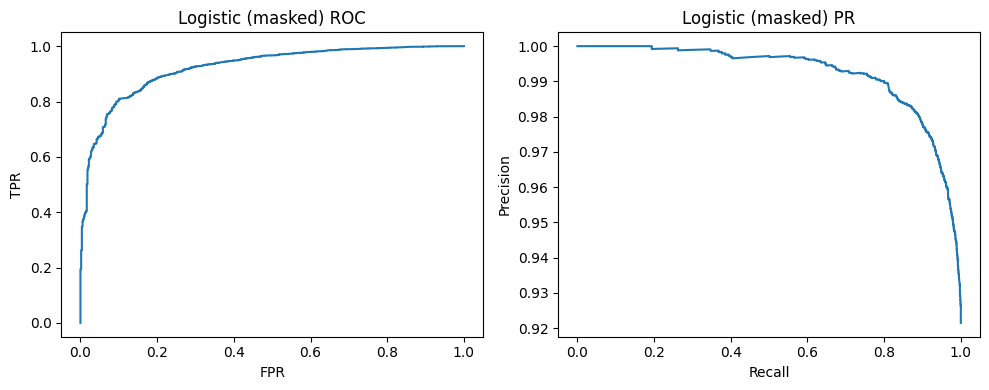

Precision@K: {'P@10': 1.0, 'P@50': 1.0, 'P@100': 1.0}
=== Logistic (unmasked) ===
AUROC: 0.9232 | AUPRC: 0.9924 | Brier: 0.1047
Confusion:
 [[ 466   80]
 [ 866 5540]]
              precision    recall  f1-score   support

           0       0.35      0.85      0.50       546
           1       0.99      0.86      0.92      6406

    accuracy                           0.86      6952
   macro avg       0.67      0.86      0.71      6952
weighted avg       0.94      0.86      0.89      6952



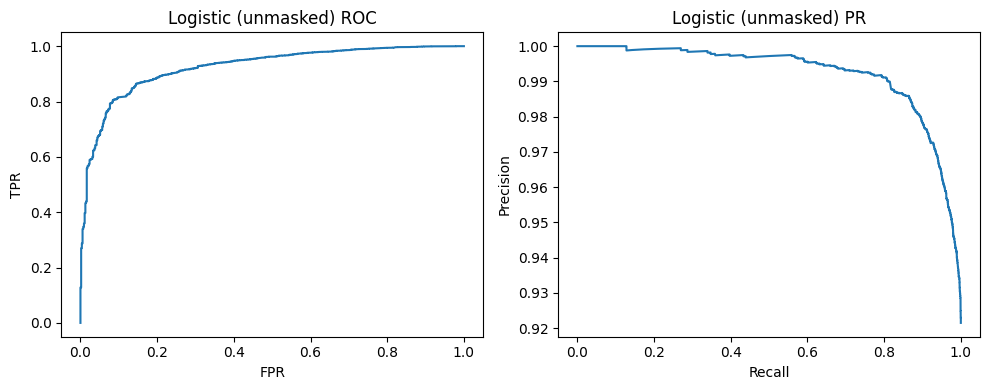

Precision@K: {'P@10': 1.0, 'P@50': 1.0, 'P@100': 1.0}
=== XGBoost (masked) ===
AUROC: 0.9074 | AUPRC: 0.9896 | Brier: 0.0474
Confusion:
 [[ 143  403]
 [  18 6388]]
              precision    recall  f1-score   support

           0       0.89      0.26      0.40       546
           1       0.94      1.00      0.97      6406

    accuracy                           0.94      6952
   macro avg       0.91      0.63      0.69      6952
weighted avg       0.94      0.94      0.92      6952



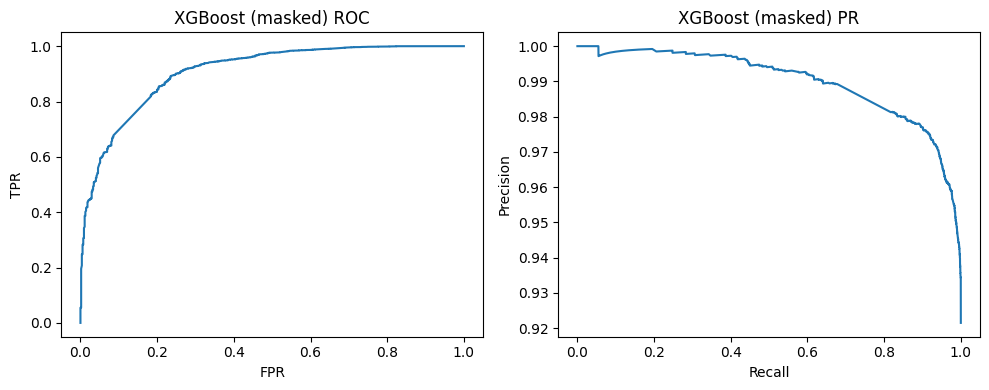

Precision@K: {'P@10': 1.0, 'P@50': 1.0, 'P@100': 1.0}
=== XGBoost (unmasked) ===
AUROC: 0.9093 | AUPRC: 0.9900 | Brier: 0.0473
Confusion:
 [[ 147  399]
 [  22 6384]]
              precision    recall  f1-score   support

           0       0.87      0.27      0.41       546
           1       0.94      1.00      0.97      6406

    accuracy                           0.94      6952
   macro avg       0.91      0.63      0.69      6952
weighted avg       0.94      0.94      0.92      6952



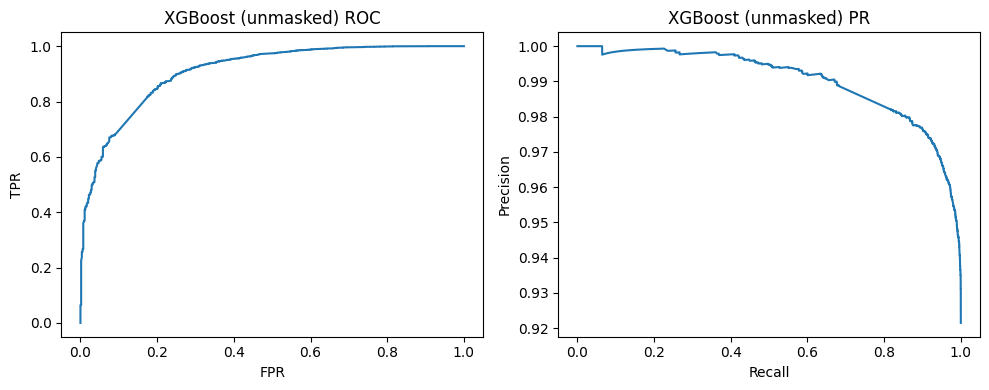

Precision@K: {'P@10': 1.0, 'P@50': 1.0, 'P@100': 1.0}
=== RandomForest (masked) ===
AUROC: 0.8639 | AUPRC: 0.9846 | Brier: 0.1973
Confusion:
 [[ 333  213]
 [ 655 5751]]
              precision    recall  f1-score   support

           0       0.34      0.61      0.43       546
           1       0.96      0.90      0.93      6406

    accuracy                           0.88      6952
   macro avg       0.65      0.75      0.68      6952
weighted avg       0.92      0.88      0.89      6952



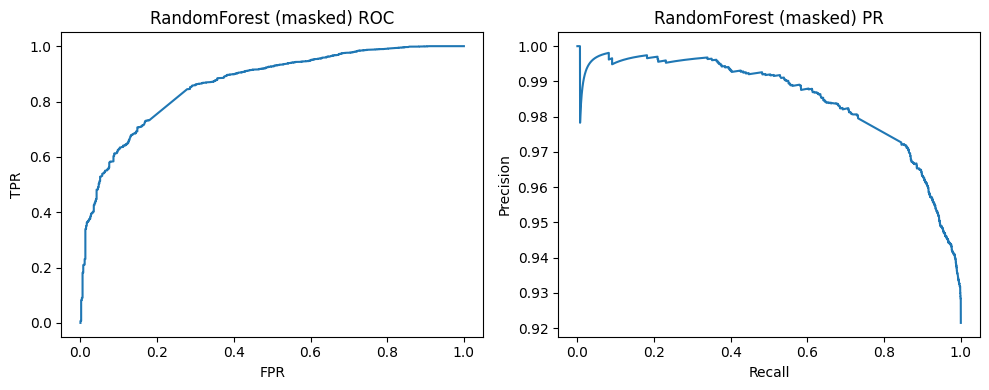

Precision@K: {'P@10': 1.0, 'P@50': 0.98, 'P@100': 0.99}


In [18]:
# Cell 18 — evaluate models on balanced test
# Logistic masked
probs_lr_mask = clf_lr_mask.predict_proba(X_te_mask)[:,1]
metrics_lr_mask = eval_preds(y_te, probs_lr_mask, name="Logistic (masked)")
print("Precision@K:", precision_at_k(y_te, probs_lr_mask, [10,50,100]))

# Logistic unmasked
probs_lr_un = clf_lr_un.predict_proba(X_te_un)[:,1]
metrics_lr_un = eval_preds(y_te, probs_lr_un, name="Logistic (unmasked)")
print("Precision@K:", precision_at_k(y_te, probs_lr_un, [10,50,100]))

# XGB masked
probs_xgb_mask = clf_xgb_mask.predict_proba(X_te_mask)[:,1]
metrics_xgb_mask = eval_preds(y_te, probs_xgb_mask, name="XGBoost (masked)")
print("Precision@K:", precision_at_k(y_te, probs_xgb_mask, [10,50,100]))

# XGB unmasked
probs_xgb_un = clf_xgb_un.predict_proba(X_te_un)[:,1]
metrics_xgb_un = eval_preds(y_te, probs_xgb_un, name="XGBoost (unmasked)")
print("Precision@K:", precision_at_k(y_te, probs_xgb_un, [10,50,100]))

# RandomForest masked
probs_rf_mask = clf_rf_mask.predict_proba(X_te_mask.toarray() if issparse(X_te_mask) else X_te_mask)[:,1]
metrics_rf_mask = eval_preds(y_te, probs_rf_mask, name="RandomForest (masked)")
print("Precision@K:", precision_at_k(y_te, probs_rf_mask, [10,50,100]))

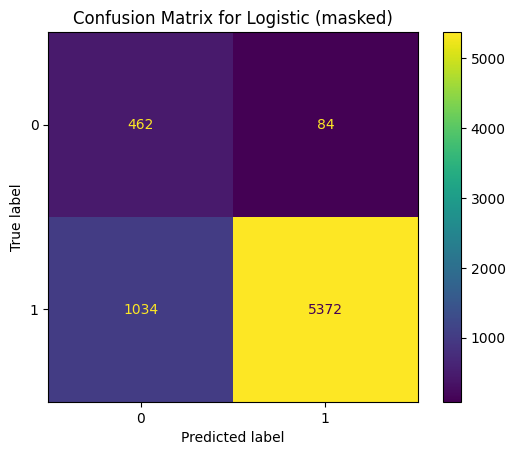

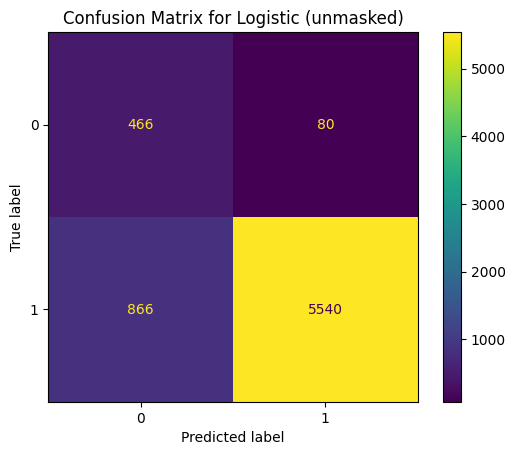

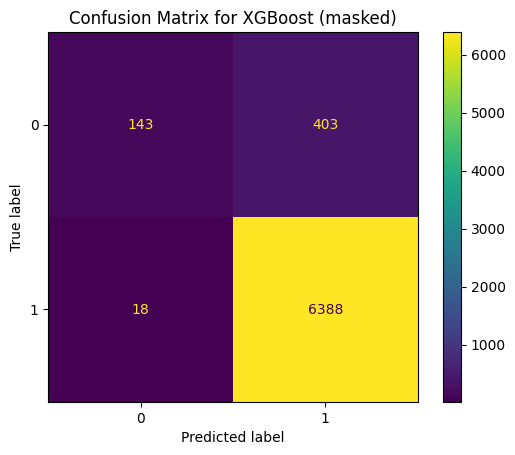

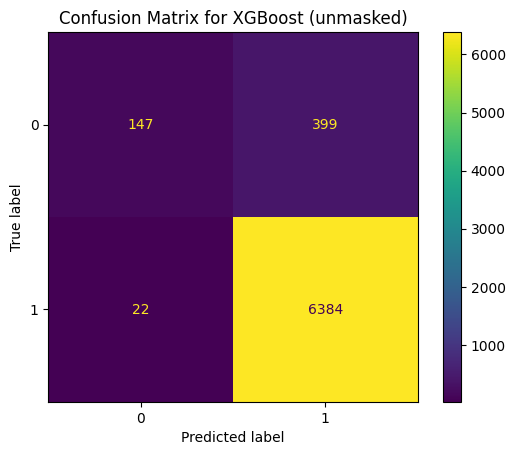

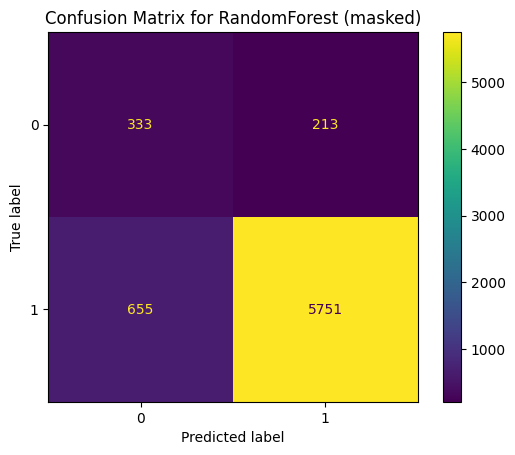

In [31]:
# Cell 18 — display confusion matrices for trained models on balanced test set
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

models = {
    "Logistic (masked)": clf_lr_mask,
    "Logistic (unmasked)": clf_lr_un,
    "XGBoost (masked)": clf_xgb_mask,
    "XGBoost (unmasked)": clf_xgb_un,
    "RandomForest (masked)": clf_rf_mask
}

X_tests = {
    "Logistic (masked)": X_te_mask,
    "Logistic (unmasked)": X_te_un,
    "XGBoost (masked)": X_te_mask,
    "XGBoost (unmasked)": X_te_un,
    "RandomForest (masked)": X_te_mask.toarray() if issparse(X_te_mask) else X_te_mask
}

for name, model in models.items():
    X_test = X_tests[name]
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_te, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Confusion Matrix for {name}")
    plt.show()

In [19]:
# Cell 19 — 5-fold stratified CV for masked XGBoost
X_all_mask = X_mask
y_all = pf['product_label_strict'].values
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RND)
aucs=[]; auprcs=[]
for train_i, test_i in skf.split(X_all_mask, y_all):
    clf = xgb.XGBClassifier(n_estimators=150, max_depth=6, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=RND, verbosity=0)
    clf.fit(X_all_mask[train_i], y_all[train_i])
    p = clf.predict_proba(X_all_mask[test_i])[:,1]
    aucs.append(roc_auc_score(y_all[test_i], p) if len(set(y_all[test_i]))>1 else np.nan)
    auprcs.append(average_precision_score(y_all[test_i], p) if len(set(y_all[test_i]))>1 else np.nan)
print("CV AUROC mean±std:", np.nanmean(aucs), np.nanstd(aucs))
print("CV AUPRC mean±std:", np.nanmean(auprcs), np.nanstd(auprcs))

CV AUROC mean±std: 0.9019703523143159 0.004377756519542431
CV AUPRC mean±std: 0.98856784663345 0.0005501907483369836


In [20]:
# Cell 20 — brand-holdout evaluation
def brand_holdout_eval(pf, model_unmasked, model_masked, tfidf_un, tfidf_mask, holdout_frac=0.20):
    # choose brands until reaching holdout_frac of products
    brands = pf['brand'].fillna('').unique().tolist()
    np.random.seed(RND); np.random.shuffle(brands)
    acc = 0; selected=[]
    total = len(pf)
    for b in brands:
        selected.append(b)
        acc += (pf['brand'].fillna('')==b).sum()
        if acc/total >= holdout_frac:
            break
    test_mask = pf['brand'].isin(selected)
    train_mask = ~test_mask
    print("Selected sample holdout brands:", selected[:8], "...")
    # prepare data
    X_test_un = tfidf_un.transform(pf.loc[test_mask, 'product_text_unmasked'].values)
    X_test_mask = tfidf_mask.transform(pf.loc[test_mask, 'product_text_masked'].values)
    y_test = pf.loc[test_mask, 'product_label_strict'].values
    # predict
    p_un = model_unmasked.predict_proba(X_test_un)[:,1]
    p_mask = model_masked.predict_proba(X_test_mask)[:,1]
    print("Unmasked AUROC:", roc_auc_score(y_test, p_un), "AUPRC:", average_precision_score(y_test, p_un))
    print("Masked   AUROC:", roc_auc_score(y_test, p_mask), "AUPRC:", average_precision_score(y_test, p_mask))
    return selected

selected = brand_holdout_eval(pf, clf_xgb_un, clf_xgb_mask, tfidf_unmasked, tfidf_masked)

Selected sample holdout brands: ['CND', 'John Paul Mitchell Systems', 'Jurlique', 'PS', 'Pure Nautica Discovery', 'VICHY', 'Erbaviva', 'Camouflage Gel'] ...
Unmasked AUROC: 0.9507023591921582 AUPRC: 0.9942666130629043
Masked   AUROC: 0.9493521853663781 AUPRC: 0.994059787846931


Brier (masked XGB) on balanced test: 0.047428658314269546


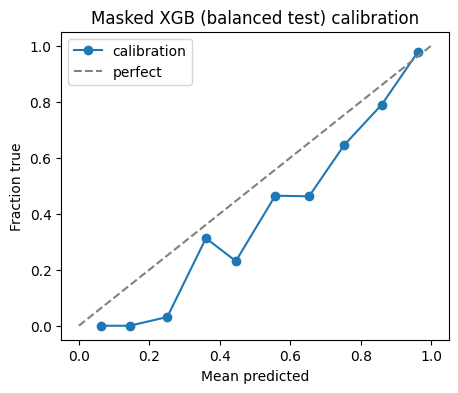

Example threshold achieving precision>=0.90: 0.5


In [21]:
# Cell 21 — calibration curve & Brier for a chosen model (masked XGBoost here)
def plot_calibration(y_true, probs, n_bins=10, title="Calibration"):
    prob_true, prob_pred = calibration_curve(y_true, probs, n_bins=n_bins)
    plt.figure(figsize=(5,4))
    plt.plot(prob_pred, prob_true, marker='o', label='calibration')
    plt.plot([0,1],[0,1],'--', color='gray', label='perfect')
    plt.xlabel('Mean predicted')
    plt.ylabel('Fraction true')
    plt.title(title)
    plt.legend()
    plt.show()

print("Brier (masked XGB) on balanced test:", brier_score_loss(y_te, probs_xgb_mask))
plot_calibration(y_te, probs_xgb_mask, n_bins=10, title="Masked XGB (balanced test) calibration")

# choose threshold by precision-recall tradeoff: e.g. choose threshold with precision >= 0.9
prec, rec, thr = precision_recall_curve(y_te, probs_xgb_mask)
best_idx = np.where(prec >= 0.9)[0]
if len(best_idx)>0:
    chosen = thr[best_idx[0]-1] if best_idx[0]>0 else 0.5
    print("Example threshold achieving precision>=0.90:", chosen)
else:
    chosen = 0.5
    print("No threshold achieves precision 0.90 — fallback to 0.5")

Top K ingredients: 123
Ingredient-model eval:
=== XGB (ingredient-presence) ===
AUROC: 0.9552 | AUPRC: 0.9925 | Brier: 0.0093
Confusion:
 [[ 487   59]
 [   7 6399]]
              precision    recall  f1-score   support

           0       0.99      0.89      0.94       546
           1       0.99      1.00      0.99      6406

    accuracy                           0.99      6952
   macro avg       0.99      0.95      0.97      6952
weighted avg       0.99      0.99      0.99      6952



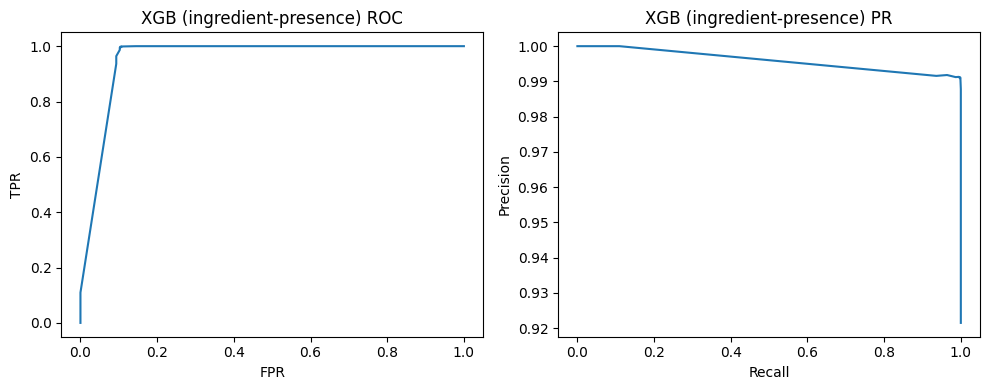

['/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/trained_models/clf_xgb_ing.joblib']

In [22]:
# Cell 22 — ingredient-presence model (multi-hot + XGBoost) and LIO
# Build top-K ingredient list
all_ings = pf['unique_ingredients'].explode().value_counts()
TOP_K_ING = min(500, len(all_ings))
top_ings = all_ings.index[:TOP_K_ING].tolist()
print("Top K ingredients:", TOP_K_ING)
mlb = MultiLabelBinarizer(classes=top_ings)
ing_lists_trimmed = pf['unique_ingredients'].apply(lambda L: [i for i in L if i in set(top_ings)])
X_ing = mlb.fit_transform(ing_lists_trimmed)

# train/test split (same balanced_test_idx)
X_tr_i = X_ing[train_idx]
X_te_i = X_ing[test_idx]
y_tr_i = y_tr
y_te_i = y_te

clf_xgb_ing = xgb.XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=RND, verbosity=0)
clf_xgb_ing.fit(X_tr_i, y_tr_i)
probs_ing = clf_xgb_ing.predict_proba(X_te_i)[:,1]
print("Ingredient-model eval:")
eval_preds(y_te_i, probs_ing, name="XGB (ingredient-presence)")
# Save mlb and model
joblib.dump(mlb, trained_dir / "mlb_ingredients.joblib")
joblib.dump(clf_xgb_ing, trained_dir / "clf_xgb_ing.joblib")

LIO global:   0%|          | 0/200 [00:00<?, ?it/s]

Saved LIO results. Top ingredients:


,ingredient,total_delta,mean_delta,count
35,titanium dioxide,7.394729e+00,3.912555e-02,189
14,carbon black,1.180734e+00,7.568809e-03,156
12,butylated hydroxyanisole,2.180703e-01,2.180703e-02,10
38,triethanolamine,3.458512e-02,3.842791e-03,9
33,styrene,2.444208e-02,4.888415e-03,5
21,ginkgo biloba extract,1.706421e-02,3.412843e-03,5
11,beta-myrcene,1.123965e-02,5.619824e-03,2
34,talc,1.002532e-02,6.265827e-04,16
20,formaldehyde (gas),9.996653e-03,1.666109e-03,6
0,"1,4-dioxane",8.839905e-03,1.767981e-03,5


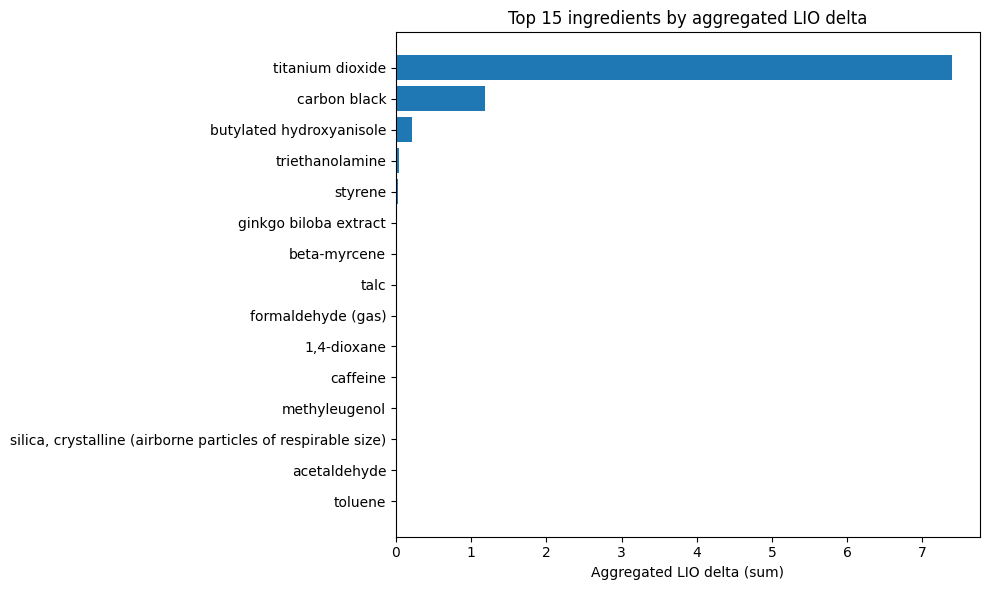

In [23]:
# Cell 23 — LIO for ingredient model (compute deltas for top-K products)
def prob_from_binary_vector(bin_vec, model):
    return model.predict_proba(bin_vec.reshape(1,-1))[:,1][0]

# compute LIO on top N predicted products (global)
N = 200
probs_all_ing = clf_xgb_ing.predict_proba(X_ing)[:,1]
order = np.argsort(-probs_all_ing)[:N]
lio_records = []
for gi in tqdm(order, desc="LIO global"):
    orig_vec = X_ing[gi].copy()
    orig_prob = prob_from_binary_vector(orig_vec, clf_xgb_ing)
    present_idx = np.where(orig_vec==1)[0]
    for j in present_idx:
        vec_wo = orig_vec.copy()
        vec_wo[j] = 0
        prob_wo = prob_from_binary_vector(vec_wo, clf_xgb_ing)
        delta = orig_prob - prob_wo
        lio_records.append({'product_index':int(gi), 'product_id':pf.iloc[gi]['_product_id'], 'ingredient': top_ings[j], 'delta':float(delta), 'orig_prob':float(orig_prob)})
lio_df = pd.DataFrame(lio_records)
global_imp = (lio_df.groupby('ingredient').agg(total_delta=('delta','sum'), mean_delta=('delta','mean'), count=('delta','count')).reset_index().sort_values('total_delta', ascending=False))
global_imp.to_csv(lio_dir / "global_ingredient_importance_from_ingmodel.csv", index=False)
lio_df.to_csv(lio_dir / "lio_all_records_ingmodel.csv", index=False)
print("Saved LIO results. Top ingredients:")
display(global_imp.head(30))

# Plot top-15 ingredients by total_delta
plt.figure(figsize=(10,6))
g = global_imp.head(15)
plt.barh(g['ingredient'][::-1], g['total_delta'][::-1])
plt.xlabel('Aggregated LIO delta (sum)')
plt.title('Top 15 ingredients by aggregated LIO delta')
plt.tight_layout()
plt.savefig(lio_dir / "top15_ingredients_lio.png", dpi=150)
plt.show()

/tmp/ipython-input-3202216993.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, features=tfidf_masked.get_feature_names_out()[:Xs.shape[1]] if hasattr(tfidf_masked,'get_feature_names_out') else None, plot_type="bar", max_display=20)


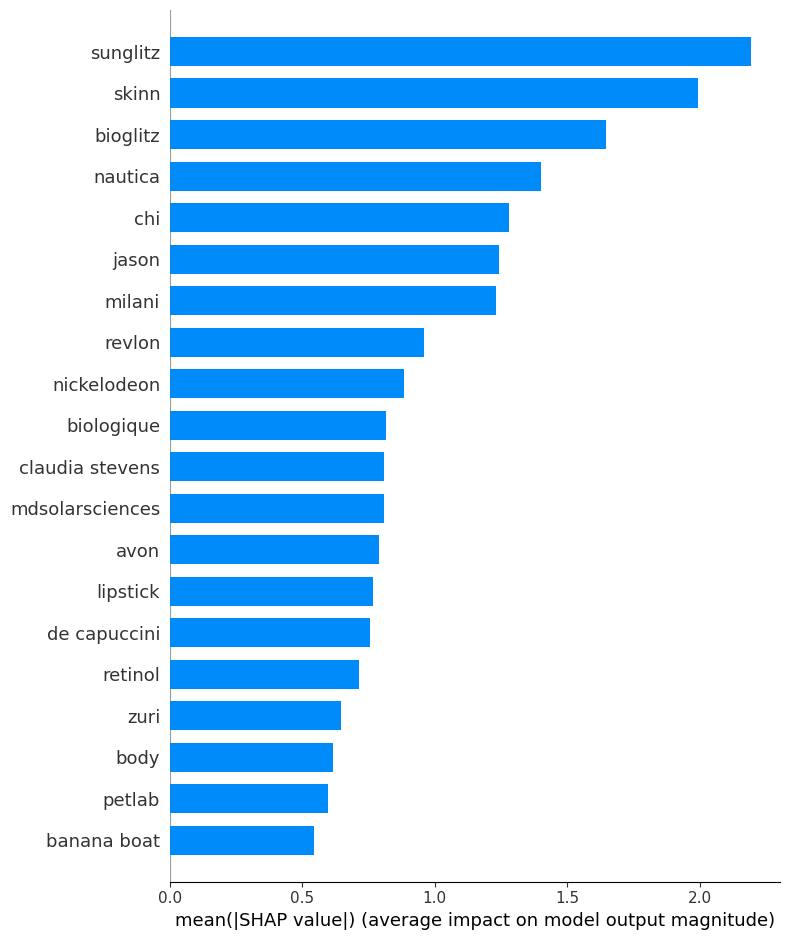

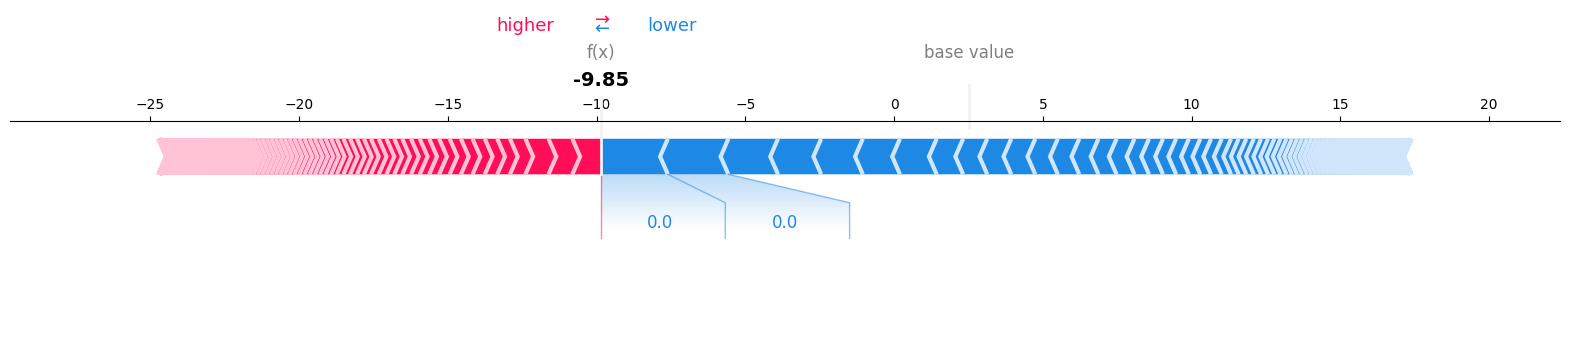

Saved SHAP sample.


In [25]:
# Cell 24 — SHAP for XGBoost masked model (sample explanations)
# WARNING: SHAP can be slow on large inputs; we run it on a small sample for interpretability only.
explainer = shap.Explainer(clf_xgb_mask)  # TreeExplainer internally
# pick 40 random validation rows
val_idx_sample = np.random.RandomState(RND).choice(test_idx, size=min(40, len(test_idx)), replace=False).tolist()
X_sample = X_mask[val_idx_sample]
# shap expects dense arrays sometimes; convert when necessary
if issparse(X_sample):
    Xs = X_sample.toarray()
else:
    Xs = X_sample
shap_values = explainer(Xs)
# summary plot (requires matplotlib)
shap.summary_plot(shap_values, features=tfidf_masked.get_feature_names_out()[:Xs.shape[1]] if hasattr(tfidf_masked,'get_feature_names_out') else None, plot_type="bar", max_display=20)
# show force plot for a single instance (in notebook this will render)
i0 = 0
shap.plots.force(shap_values[i0], matplotlib=True)
# Save a shap sample file for later
joblib.dump({'explainer':explainer, 'shap_values':shap_values, 'indices':val_idx_sample}, lio_dir / "shap_masked_sample.joblib")
print("Saved SHAP sample.")

In [26]:
# Cell 25 — LIME text explanations (explain a single product)
# LIME text explainer expects raw text and class names
class_names = ['no_strict_flag', 'strict_flag']
explainer_lime = LimeTextExplainer(class_names=class_names, random_state=RND)
# pick an index from balanced_test_idx
idx_example = balanced_test_idx[0]
text_to_explain = pf.loc[idx_example, 'product_text_unmasked']
print("Explaining:", text_to_explain)
# function to predict probabilities for raw texts (unmasked) using tfidf_unmasked + clf_xgb_un (wrap)
def predict_proba_texts(texts):
    X = tfidf_unmasked.transform(texts)
    return clf_xgb_un.predict_proba(X)

exp = explainer_lime.explain_instance(text_to_explain, predict_proba_texts, num_features=10)
print("LIME explanation (top features):")
display(exp.as_list())
# save explanation html
exp.save_to_file(str(lio_dir / "lime_example.html"))
print("Saved LIME example to", lio_dir / "lime_example.html")


Explaining: Superdad Bath Bomb Lush Manufacturing Ltd
LIME explanation (top features):


[(np.str_('Bomb'), 0.0164427953050619),
 (np.str_('Ltd'), 0.013237975321277861),
 (np.str_('Bath'), -0.010871021268333537),
 (np.str_('Lush'), 0.006524186001492655),
 (np.str_('Manufacturing'), 0.0017666822540076707),
 (np.str_('Superdad'), -0.0013221744993000327)]

Saved LIME example to /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/lio_results/lime_example.html


In [32]:
# Cell 28 — Visualize LIME explanation
from IPython.display import HTML

lime_html_path = lio_dir / "lime_example.html"
if lime_html_path.exists():
    print(f"Displaying LIME explanation from {lime_html_path}")
    display(HTML(filename=str(lime_html_path)))
else:
    print(f"LIME explanation file not found at {lime_html_path}")

Displaying LIME explanation from /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/lio_results/lime_example.html


In [28]:
# Cell 26 — permutation importance for masked logistic model (top tokens)
from sklearn.inspection import permutation_importance
# use X_te_mask and y_te as validation
res_perm = permutation_importance(clf_lr_mask, X_te_mask.toarray(), y_te, n_repeats=10, random_state=RND, n_jobs=2)
tokens = tfidf_masked.get_feature_names_out()
top_idx = np.argsort(res_perm.importances_mean)[-40:][::-1]
perm_df = pd.DataFrame({'token':tokens[top_idx], 'importance_mean':res_perm.importances_mean[top_idx], 'importance_std':res_perm.importances_std[top_idx]})
perm_df.to_csv(processed_dir / "permutation_importance_masked_top_tokens.csv", index=False)
display(perm_df)
print("Saved permutation_importance_masked_top_tokens.csv")

,token,importance_mean,importance_std
0,lumene,0.003769,0.000396
1,carpet manicure,0.002704,0.000125
2,red carpet,0.002690,0.000158
3,carpet,0.002690,0.000158
4,gel polish,0.002632,0.000441
5,works,0.002402,0.000232
6,bath body,0.002316,0.000261
7,chi,0.002258,0.000535
8,nail,0.002043,0.000724
9,shampoo,0.002043,0.000713


Saved permutation_importance_masked_top_tokens.csv


In [29]:
# Cell 27 — save final artifacts and a manifest
artifacts = {
    'processed': [
        "main_deduped_rows.csv",
        "chem_unique_and_exactflags.csv",
        "chemical_labels_from_main.csv",
        "ingredient_flag_occurrence_summary.csv",
        "product_level_flags_initial.csv",
        f"product_level_flags_strict_{LABEL_OPTION}.csv",
        "product_level_flags_with_texts.csv",
        "train_idx.csv","balanced_test_idx.csv"
    ],
    'models': [
        "trained_models/tfidf_unmasked.joblib",
        "trained_models/tfidf_masked.joblib",
        "trained_models/clf_lr_mask.joblib",
        "trained_models/clf_lr_un.joblib",
        "trained_models/clf_xgb_mask.joblib",
        "trained_models/clf_xgb_un.joblib",
        "trained_models/clf_rf_mask.joblib",
        "trained_models/mlb_ingredients.joblib",
        "trained_models/clf_xgb_ing.joblib"
    ],
    'lio': [
        "lio_results/global_ingredient_importance_from_ingmodel.csv",
        "lio_results/lio_all_records_ingmodel.csv",
        "lio_results/top15_ingredients_lio.png"
    ],
    'plots': [
        "processed/permutation_importance_masked_top_tokens.csv",
        "processed/examples_product_names_with_ingredient_tokens.csv",
        "processed/manual_review_sample_100.csv"
    ]
}
(Path(base) / "pipeline_manifest.json").write_text(json.dumps(artifacts, indent=2))
print("Saved pipeline_manifest.json to base folder. Artifacts list printed above.")

Saved pipeline_manifest.json to base folder. Artifacts list printed above.


In [33]:
# Cell A — env info + load artifacts (run once)
import os, sys, platform, time, json
from pathlib import Path
import joblib, psutil
import multiprocessing

base = "/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics"
trained_dir = Path(base) / "trained_models"
processed_dir = Path(base) / "processed"

# models / vectorizers you saved earlier
artifacts = {
    'tfidf_unmasked': trained_dir / "tfidf_unmasked.joblib",
    'tfidf_masked'  : trained_dir / "tfidf_masked.joblib",
    'clf_lr_mask'   : trained_dir / "clf_lr_mask.joblib",
    'clf_lr_un'     : trained_dir / "clf_lr_un.joblib",
    'clf_xgb_mask'  : trained_dir / "clf_xgb_mask.joblib",
    'clf_xgb_un'    : trained_dir / "clf_xgb_un.joblib",
    'clf_rf_mask'   : trained_dir / "clf_rf_mask.joblib",
    'mlb_ingredients': trained_dir / "mlb_ingredients.joblib",
    'clf_xgb_ing'   : trained_dir / "clf_xgb_ing.joblib"
}

print("Artifacts existence:")
for k,v in artifacts.items():
    print(f" - {k}: {v.exists()}")

# load those that exist
loaded = {}
for k,v in artifacts.items():
    if v.exists():
        try:
            loaded[k] = joblib.load(v)
            print(f"Loaded {k}")
        except Exception as e:
            print(f"Failed to load {k}: {e}")

# Small helper to show model predict method presence
for k, m in loaded.items():
    if hasattr(m, "predict_proba"):
        print(f"{k} -> predict_proba OK")
    elif hasattr(m, "predict"):
        print(f"{k} -> predict only")
    else:
        print(f"{k} -> no predict method detected")

# Environment info
env = {
    'python': sys.version.replace('\n',' '),
    'platform': platform.platform(),
    'cpu_count_physical': psutil.cpu_count(logical=False),
    'cpu_count_logical' : psutil.cpu_count(logical=True),
    'memory_total_gb': round(psutil.virtual_memory().total / (1024**3),2),
    'cwd': os.getcwd(),
    'gpu_available': False
}
# check for nvidia
try:
    gpu_info = os.popen('nvidia-smi --query-gpu=name,memory.total --format=csv,noheader').read().strip()
    if gpu_info:
        env['gpu_available'] = True
        env['gpu_info'] = gpu_info
except Exception:
    pass

print("\nENV INFO:")
print(json.dumps(env, indent=2))
# expose loaded artifacts for next cell
globals().update(loaded)
print("\nReady. Now run the inference-benchmark cell.")

Artifacts existence:
 - tfidf_unmasked: True
 - tfidf_masked: True
 - clf_lr_mask: True
 - clf_lr_un: True
 - clf_xgb_mask: True
 - clf_xgb_un: True
 - clf_rf_mask: True
 - mlb_ingredients: True
 - clf_xgb_ing: True
Loaded tfidf_unmasked
Loaded tfidf_masked
Loaded clf_lr_mask
Loaded clf_lr_un
Loaded clf_xgb_mask
Loaded clf_xgb_un
Loaded clf_rf_mask
Loaded mlb_ingredients
Loaded clf_xgb_ing
tfidf_unmasked -> no predict method detected
tfidf_masked -> no predict method detected
clf_lr_mask -> predict_proba OK
clf_lr_un -> predict_proba OK
clf_xgb_mask -> predict_proba OK
clf_xgb_un -> predict_proba OK
clf_rf_mask -> predict_proba OK
mlb_ingredients -> no predict method detected
clf_xgb_ing -> predict_proba OK

ENV INFO:
{
  "python": "3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]",
  "platform": "Linux-6.1.123+-x86_64-with-glibc2.35",
  "cpu_count_physical": 1,
  "cpu_count_logical": 2,
  "memory_total_gb": 12.67,
  "cwd": "/content",
  "gpu_available": false
}

Ready. Now run the i

In [34]:
# Cell B — inference time & throughput benchmarking
import time, numpy as np, pandas as pd
from pathlib import Path
from statistics import mean, median, stdev

base = "/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics"
processed_dir = Path(base) / "processed"
processed_dir.mkdir(parents=True, exist_ok=True)

# Use loaded objects from previous cell (tfidf_masked, tfidf_unmasked, clf_* etc.)
# If you didn't load masked/unmasked prefer masked versions for E2E measurements
tfidf_masked = globals().get('tfidf_masked', None)
tfidf_unmasked = globals().get('tfidf_unmasked', None)
clf_lr_mask = globals().get('clf_lr_mask', None)
clf_lr_un = globals().get('clf_lr_un', None)
clf_xgb_mask = globals().get('clf_xgb_mask', None)
clf_xgb_un = globals().get('clf_xgb_un', None)
clf_rf_mask = globals().get('clf_rf_mask', None)
mlb_ingredients = globals().get('mlb_ingredients', None)
clf_xgb_ing = globals().get('clf_xgb_ing', None)

# Simple synthetic inputs for benchmarking (safe, avoids I/O overhead)
# Create representative product texts by repeating a short sentence with brand
sample_texts = [
    "nail lacquer opi", "hydrating body lotion dove spf", "matte lipstick revlon",
    "shampoo moisturizing head & shoulders", "face cream spf50 neutrogena"
]
# Expand to large list
sample_texts = (sample_texts * 50)[:1024]  # up to 1024 samples for large batch testing

# helper timers
def time_function(func, *args, n_iters=20, warmup=10):
    # warm-up
    for _ in range(warmup):
        func(*args)
    times = []
    for _ in range(n_iters):
        t0 = time.perf_counter()
        func(*args)
        t1 = time.perf_counter()
        times.append(t1-t0)
    return times

results = []

# Measures to run:
# 1) E2E: vectorizer.transform + model.predict_proba for masked and unmasked
# 2) model-only: predict_proba on dense arrays (or sparse, as required)
# 3) ingredient-model: model-only on binary vector
# For each model/batch_size: measure median, mean, std, p50/p90/p99, throughput

batch_sizes = [1, 8, 32, 128]

def summarize(times):
    arr = np.array(times)
    return {
        'runs': len(arr),
        'mean_s': float(arr.mean()),
        'median_s': float(np.median(arr)),
        'std_s': float(arr.std(ddof=1) if len(arr)>1 else 0.0),
        'p90_s': float(np.percentile(arr,90)),
        'p99_s': float(np.percentile(arr,99))
    }

print("Benchmarking E2E and model-only. This will take a few minutes...")

# E2E masked logistic
if tfidf_masked is not None and clf_lr_mask is not None:
    for B in batch_sizes:
        texts = sample_texts[:B]
        def e2e_masked_lr(txts):
            X = tfidf_masked.transform(txts)
            _ = clf_lr_mask.predict_proba(X)
        times = time_function(e2e_masked_lr, texts, n_iters=15, warmup=8)
        summary = summarize(times)
        throughput = [B / t for t in times]
        results.append({
            'pipeline':'e2e_masked_tfidf+lr',
            'model':'logistic_masked',
            'batch_size':B,
            **summary,
            'median_latency_ms': summary['median_s']*1000,
            'median_throughput_eps': float(np.median(throughput))
        })
        print(f"e2e_masked_lr B={B} median {summary['median_s']*1000:.2f} ms, throughput {np.median(throughput):.1f} eps")

# Model-only masked logistic (precompute features)
if tfidf_masked is not None and clf_lr_mask is not None:
    for B in batch_sizes:
        X = tfidf_masked.transform(sample_texts[:B])
        def model_only_lr(xmat):
            _ = clf_lr_mask.predict_proba(xmat)
        times = time_function(model_only_lr, X, n_iters=15, warmup=8)
        summary = summarize(times)
        throughput = [B / t for t in times]
        results.append({
            'pipeline':'modelonly_masked_lr',
            'model':'logistic_masked',
            'batch_size':B,
            **summary,
            'median_latency_ms': summary['median_s']*1000,
            'median_throughput_eps': float(np.median(throughput))
        })
        print(f"modelonly_masked_lr B={B} median {summary['median_s']*1000:.2f} ms, throughput {np.median(throughput):.1f} eps")

# Repeat for XGBoost masked
if tfidf_masked is not None and clf_xgb_mask is not None:
    for B in batch_sizes:
        texts = sample_texts[:B]
        def e2e_masked_xgb(txts):
            X = tfidf_masked.transform(txts)
            _ = clf_xgb_mask.predict_proba(X)
        times = time_function(e2e_masked_xgb, texts, n_iters=12, warmup=6)
        summary = summarize(times)
        throughput = [B / t for t in times]
        results.append({
            'pipeline':'e2e_masked_tfidf+xgb',
            'model':'xgb_masked',
            'batch_size':B,
            **summary,
            'median_latency_ms': summary['median_s']*1000,
            'median_throughput_eps': float(np.median(throughput))
        })
        print(f"e2e_masked_xgb B={B} median {summary['median_s']*1000:.2f} ms, throughput {np.median(throughput):.1f} eps")

    # model-only XGB
    for B in batch_sizes:
        X = tfidf_masked.transform(sample_texts[:B])
        def model_only_xgb(xmat):
            _ = clf_xgb_mask.predict_proba(xmat)
        times = time_function(model_only_xgb, X, n_iters=12, warmup=6)
        summary = summarize(times)
        throughput = [B / t for t in times]
        results.append({
            'pipeline':'modelonly_masked_xgb',
            'model':'xgb_masked',
            'batch_size':B,
            **summary,
            'median_latency_ms': summary['median_s']*1000,
            'median_throughput_eps': float(np.median(throughput))
        })
        print(f"modelonly_masked_xgb B={B} median {summary['median_s']*1000:.2f} ms, throughput {np.median(throughput):.1f} eps")

# Ingredient model (binary vector) — measure model-only
if mlb_ingredients is not None and clf_xgb_ing is not None:
    for B in batch_sizes:
        # produce binary matrices
        sample_lists = [ ['titanium dioxide','toluene'] for _ in range(B)]
        X_bin = mlb_ingredients.transform(sample_lists)
        def model_only_ing(xmat):
            _ = clf_xgb_ing.predict_proba(xmat)
        times = time_function(model_only_ing, X_bin, n_iters=12, warmup=6)
        summary = summarize(times)
        throughput = [B / t for t in times]
        results.append({
            'pipeline':'modelonly_ing_xgb',
            'model':'xgb_ing',
            'batch_size':B,
            **summary,
            'median_latency_ms': summary['median_s']*1000,
            'median_throughput_eps': float(np.median(throughput))
        })
        print(f"modelonly_ing_xgb B={B} median {summary['median_s']*1000:.2f} ms, throughput {np.median(throughput):.1f} eps")

# Save results
res_df = pd.DataFrame(results)
outp = processed_dir / "inference_benchmark_results.csv"
res_df.to_csv(outp, index=False)
print("Saved benchmark results to:", outp)
display(res_df)

Benchmarking E2E and model-only. This will take a few minutes...
e2e_masked_lr B=1 median 1.05 ms, throughput 956.0 eps
e2e_masked_lr B=8 median 1.37 ms, throughput 5844.8 eps
e2e_masked_lr B=32 median 1.78 ms, throughput 17950.6 eps
e2e_masked_lr B=128 median 2.84 ms, throughput 45049.6 eps
modelonly_masked_lr B=1 median 0.28 ms, throughput 3532.3 eps
modelonly_masked_lr B=8 median 0.26 ms, throughput 30705.8 eps
modelonly_masked_lr B=32 median 0.29 ms, throughput 108606.7 eps
modelonly_masked_lr B=128 median 0.28 ms, throughput 449389.3 eps
e2e_masked_xgb B=1 median 1.77 ms, throughput 565.6 eps
e2e_masked_xgb B=8 median 1.78 ms, throughput 4493.5 eps
e2e_masked_xgb B=32 median 5.80 ms, throughput 5759.1 eps
e2e_masked_xgb B=128 median 4.18 ms, throughput 30668.3 eps
modelonly_masked_xgb B=1 median 0.60 ms, throughput 1683.5 eps
modelonly_masked_xgb B=8 median 0.80 ms, throughput 10080.1 eps
modelonly_masked_xgb B=32 median 2.07 ms, throughput 19410.0 eps
modelonly_masked_xgb B=128 m

,pipeline,model,batch_size,runs,mean_s,median_s,std_s,p90_s,p99_s,median_latency_ms,median_throughput_eps
0,e2e_masked_tfidf+lr,logistic_masked,1,15,0.002795,0.001046,0.003698,0.009429,0.010977,1.045983,956.038482
1,e2e_masked_tfidf+lr,logistic_masked,8,15,0.004330,0.001369,0.004628,0.011581,0.011725,1.368727,5844.847072
2,e2e_masked_tfidf+lr,logistic_masked,32,15,0.006194,0.001783,0.006520,0.015505,0.019541,1.782669,17950.612256
3,e2e_masked_tfidf+lr,logistic_masked,128,15,0.003396,0.002841,0.001561,0.003815,0.008217,2.841311,45049.626741
4,modelonly_masked_lr,logistic_masked,1,15,0.000295,0.000283,0.000047,0.000317,0.000432,0.283102,3532.295779
5,modelonly_masked_lr,logistic_masked,8,15,0.000269,0.000261,0.000022,0.000289,0.000318,0.260537,30705.811455
6,modelonly_masked_lr,logistic_masked,32,15,0.000303,0.000295,0.000034,0.000317,0.000400,0.294641,108606.745164
7,modelonly_masked_lr,logistic_masked,128,15,0.000287,0.000285,0.000023,0.000303,0.000346,0.284831,449389.286910
8,e2e_masked_tfidf+xgb,xgb_masked,1,12,0.006656,0.001769,0.010114,0.010620,0.034002,1.769168,565.619914
9,e2e_masked_tfidf+xgb,xgb_masked,8,12,0.003115,0.001782,0.002828,0.004833,0.010421,1.782481,4493.503537


In [35]:
import os
from pathlib import Path
base="/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/trained_models"
for f in Path(base).glob("*.joblib"):
    print(f.name, f.stat().st_size/1024**2, "MB")

tfidf_unmasked.joblib 0.07303237915039062 MB
tfidf_masked.joblib 0.07308197021484375 MB
clf_lr_mask.joblib 0.016097068786621094 MB
clf_lr_un.joblib 0.016097068786621094 MB
clf_xgb_mask.joblib 0.2842731475830078 MB
clf_xgb_un.joblib 0.28154945373535156 MB
clf_rf_mask.joblib 2.4105920791625977 MB
mlb_ingredients.joblib 0.006317138671875 MB
clf_xgb_ing.joblib 0.22720718383789062 MB


In [36]:
import time
import shap
# use small subset Xs (dense)
Xs = X_mask[test_idx[:10]].toarray() if issparse(X_mask) else X_mask[test_idx[:10]]
explainer = shap.Explainer(clf_xgb_mask)
t0=time.perf_counter()
_ = explainer(Xs)   # global summary for small batch
t1=time.perf_counter()
print("SHAP sample time:", t1-t0, "s ; per instance:", (t1-t0)/len(Xs), "s")

SHAP sample time: 0.010152822000236483 s ; per instance: 0.0010152822000236484 s


Saved plot to: /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/processed/artifact_size_vs_latency.png


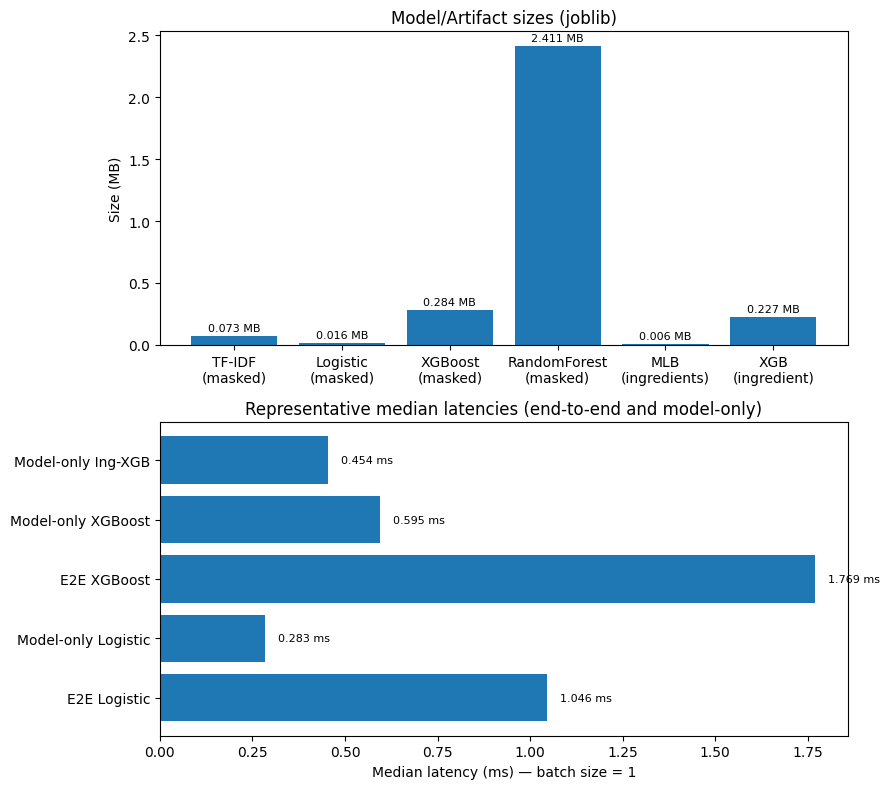

In [37]:
# Cell 1: artifact-size vs E2E median latency plot (saves PNG to Drive)
import os, math
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

base = Path("/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics")
trained = base / "trained_models"
processed = base / "processed"
benchmark_csv = processed / "inference_benchmark_results.csv"
out_png = processed / "artifact_size_vs_latency.png"

# --- 1) gather artifact sizes (MB) from trained_models folder ---
artifact_files = {
    'tfidf_masked': trained / "tfidf_masked.joblib",
    'tfidf_unmasked': trained / "tfidf_unmasked.joblib",
    'logistic_masked': trained / "clf_lr_mask.joblib",
    'logistic_unmasked': trained / "clf_lr_un.joblib",
    'xgb_masked': trained / "clf_xgb_mask.joblib",
    'xgb_unmasked': trained / "clf_xgb_un.joblib",
    'rf_masked': trained / "clf_rf_mask.joblib",
    'mlb_ingredients': trained / "mlb_ingredients.joblib",
    'xgb_ingredient': trained / "clf_xgb_ing.joblib"
}

sizes = {}
for k, p in artifact_files.items():
    if p.exists():
        sizes[k] = p.stat().st_size / (1024.0**2)  # MB
    else:
        sizes[k] = float('nan')

# --- 2) read benchmark CSV and extract representative medians for E2E B=1 ---
if not benchmark_csv.exists():
    raise FileNotFoundError(f"Benchmark CSV not found at {benchmark_csv}. Run the inference benchmark cell first.")
df = pd.read_csv(benchmark_csv)

# Helper: find median_latency_ms for pipeline names (batch_size 1)
def find_median_latency(pipeline_name):
    row = df[(df['pipeline']==pipeline_name) & (df['batch_size']==1)]
    if len(row)==0:
        return float('nan')
    return float(row['median_latency_ms'].values[0])

lat_e2e_lr = find_median_latency('e2e_masked_tfidf+lr')
lat_e2e_xgb = find_median_latency('e2e_masked_tfidf+xgb')
# model-only medians:
def find_modelonly_median(model_name):
    row = df[(df['pipeline'].str.contains('modelonly')) & (df['model']==model_name) & (df['batch_size']==1)]
    if len(row)==0:
        return float('nan')
    return float(row['median_latency_ms'].values[0])

lat_modelonly_lr = find_modelonly_median('logistic_masked')
lat_modelonly_xgb = find_modelonly_median('xgb_masked')
lat_modelonly_ing = find_modelonly_median('xgb_ing')

# --- 3) Prepare plotting data ---
# Artifact plot items (only plot the most relevant artifacts)
artifact_keys_order = ['tfidf_masked','logistic_masked','xgb_masked','rf_masked','mlb_ingredients','xgb_ingredient']
artifact_labels = {
    'tfidf_masked': 'TF-IDF\n(masked)',
    'logistic_masked': 'Logistic\n(masked)',
    'xgb_masked': 'XGBoost\n(masked)',
    'rf_masked': 'RandomForest\n(masked)',
    'mlb_ingredients': 'MLB\n(ingredients)',
    'xgb_ingredient': 'XGB\n(ingredient)'
}
artifact_sizes = [sizes.get(k, float('nan')) for k in artifact_keys_order]
# Latency plot (ms) — show E2E and model-only for LR and XGB
latency_labels = ['E2E Logistic', 'Model-only Logistic', 'E2E XGBoost', 'Model-only XGBoost', 'Model-only Ing-XGB']
latency_values = [lat_e2e_lr, lat_modelonly_lr, lat_e2e_xgb, lat_modelonly_xgb, lat_modelonly_ing]

# --- 4) Plotting with matplotlib (two stacked subplots) ---
plt.rcParams.update({'figure.max_open_warning': 0})
fig, axes = plt.subplots(2, 1, figsize=(9, 8), tight_layout=True)

# Top: artifact sizes (MB)
ax = axes[0]
x = np.arange(len(artifact_keys_order))
ax.bar(x, artifact_sizes)
ax.set_xticks(x)
ax.set_xticklabels([artifact_labels[k] for k in artifact_keys_order], rotation=0)
ax.set_ylabel("Size (MB)")
ax.set_title("Model/Artifact sizes (joblib)")

# Annotate sizes
for i, v in enumerate(artifact_sizes):
    if not math.isnan(v):
        ax.text(i, v + max(artifact_sizes)*0.01 if max(artifact_sizes)>0 else v+0.001, f"{v:.3f} MB", ha='center', va='bottom', fontsize=8)

# Bottom: latencies (ms)
ax2 = axes[1]
y = np.arange(len(latency_labels))
ax2.barh(y, latency_values)
ax2.set_yticks(y)
ax2.set_yticklabels(latency_labels)
ax2.set_xlabel("Median latency (ms) — batch size = 1")
ax2.set_title("Representative median latencies (end-to-end and model-only)")
# annotate values
for i, v in enumerate(latency_values):
    if not math.isnan(v):
        ax2.text(v + (max(latency_values)*0.02 if max(latency_values)>0 else 0.0001), i, f"{v:.3f} ms", va='center', fontsize=8)

plt.savefig(out_png, dpi=200)
print("Saved plot to:", out_png)
plt.show()

In [38]:
# Cell 2: measure SHAP explanation + force-plot save time per instance (saves HTML)
import time, json
from pathlib import Path
import joblib
import pandas as pd
import numpy as np
import shap

base = Path("/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics")
trained = base / "trained_models"
processed = base / "processed"
out_html = processed / "shap_force_example.html"
report_json = processed / "shap_force_timing_report.json"

# Load artifacts (TF-IDF masked + XGBoost masked)
tfidf_masked_p = trained / "tfidf_masked.joblib"
xgb_masked_p = trained / "clf_xgb_mask.joblib"
if not (tfidf_masked_p.exists() and xgb_masked_p.exists()):
    raise FileNotFoundError("Required artifacts tfidf_masked or clf_xgb_mask not found in trained_models.")

tfidf = joblib.load(tfidf_masked_p)
xgb = joblib.load(xgb_masked_p)

# Choose a sample product text (try to use your real data if available)
sample_texts = [
    "alessandro international striplac 04 heavens nude",
    "hydrating body lotion dove spf",
    "matte lipstick revlon",
    "shampoo moisturizing head & shoulders",
    "face cream spf50 neutrogena"
]
sample_text = sample_texts[0]

# Transform to features (dense) for SHAP
X_sparse = tfidf.transform([sample_text])  # sparse matrix
try:
    X = X_sparse.toarray()
except Exception:
    # fallback: use as-is
    X = X_sparse

# Create TreeExplainer (fast for tree models)
expl = shap.TreeExplainer(xgb)

# 1) measure explanation computation time (shap values)
t0 = time.perf_counter()
# shap_values may be returned as array or list depending on model; handle generically
shap_values = expl.shap_values(X) if hasattr(expl, "shap_values") else expl(X)
t1 = time.perf_counter()
explain_time_s = t1 - t0

# 2) measure time to generate and save a force plot HTML (includes generating the figure and serializing)
# We'll try to use shap.force_plot + shap.save_html (works with many SHAP versions)
try:
    # get expected value; handle different return types
    try:
        expected_value = expl.expected_value
    except Exception:
        # fallback: use mean of expl(X).base_values if available
        try:
            base_exp = expl(X)
            expected_value = getattr(base_exp, "base_values", None)
        except Exception:
            expected_value = None

    t0 = time.perf_counter()
    # shap.force_plot signature varies — try a few safe calls
    try:
        # If shap_values is list (multi-class), pick index 1 or 0
        if isinstance(shap_values, list):
            sv = shap_values[0]
        else:
            sv = shap_values
        # use feature names if available
        try:
            feature_names = tfidf.get_feature_names_out()
        except Exception:
            feature_names = None
        force_plot = shap.force_plot(expected_value, sv[0], feature_names=feature_names, matplotlib=False)
        # save html
        shap.save_html(str(out_html), force_plot)
        t1 = time.perf_counter()
        save_html_time_s = t1 - t0
        success = True
    except Exception as e:
        # fallback: try the newer expl(...) -> returns Explanation object; use shap.plots.force on it
        try:
            t0 = time.perf_counter()
            expl_out = expl(X)  # Explanation object
            fp = shap.plots.force(expl_out[0], show=False)
            shap.save_html(str(out_html), fp)
            t1 = time.perf_counter()
            save_html_time_s = t1 - t0
            success = True
        except Exception as e2:
            save_html_time_s = None
            success = False
            error = (str(e), str(e2))
except Exception as e:
    save_html_time_s = None
    explain_time_s = explain_time_s
    success = False
    error = str(e)

# Save a small JSON report
report = {
    "sample_text": sample_text,
    "explain_time_s": explain_time_s,
    "save_html_time_s": save_html_time_s,
    "force_html_saved": str(out_html) if success else None,
}
Path(processed).mkdir(parents=True, exist_ok=True)
report_path = processed / "shap_force_timing_report.json"
report_path.write_text(json.dumps(report, indent=2))
print("Saved report ->", report_path)
print(json.dumps(report, indent=2))

if success:
    print("Saved SHAP force-plot HTML to:", out_html)
else:
    print("Failed to generate or save force-plot HTML. See report for error details.")

Saved report -> /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/processed/shap_force_timing_report.json
{
  "sample_text": "alessandro international striplac 04 heavens nude",
  "explain_time_s": 0.09556682599941269,
  "save_html_time_s": 0.13470411500020418,
  "force_html_saved": "/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/processed/shap_force_example.html"
}
Saved SHAP force-plot HTML to: /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/processed/shap_force_example.html


In [39]:
print("Have a good day!")

Have a good day!
